In [ ]:

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

from keras import backend as K
from keras.layers.core import Activation, Dense
from keras.layers import Flatten, Reshape
from keras.engine.input_layer import Input
from keras.optimizers import Adam, RMSprop
from keras.layers.convolutional import Conv1D
from keras.layers.merge import concatenate
from keras.models import Model



In [ ]:
msg = 16
key = 16
cipher = 16

In [ ]:
K.clear_session()
pad = 'same'

alice_msg = Input(shape=(msg,)) 
alice_key = Input(shape=(key,)) 
alice_input = concatenate([alice_msg, alice_key], axis=1)


alice_fc1 = Dense(units=(msg + key))(alice_input)
alice_fc1a = Activation('tanh')(alice_fc1)
alice_reshape = Reshape((msg + key, 1,))(alice_fc1a)

aconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(alice_reshape)
aconv1a = Activation('tanh')(aconv1)
aconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(aconv1a)
aconv2a = Activation('tanh')(aconv2)
aconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(aconv2a)
aconv3a = Activation('tanh')(aconv3)
aconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(aconv3a)
aconv4a = Activation('sigmoid')(aconv4)

alice_output = Flatten()(aconv4a)

alice = Model([alice_msg, alice_key], alice_output, name='alice')


In [ ]:
bob_cipher = Input(shape=(cipher,)) 
bob_key = Input(shape=(key,)) 
bob_input = concatenate([bob_cipher, bob_key], axis=1)

bob_fc1 = Dense(units=(cipher + key))(bob_input)
bob_fc1a = Activation('tanh')(bob_fc1)

bob_reshape = Reshape((cipher + key, 1,))(bob_fc1a)

bconv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(bob_reshape)
bconv1a = Activation('tanh')(bconv1)
bconv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(bconv1a)
bconv2a = Activation('tanh')(bconv2)
bconv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(bconv2a)
bconv3a = Activation('tanh')(bconv3)
bconv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(bconv3a)
bconv4a = Activation('sigmoid')(bconv4)

bob_output = Flatten()(bconv4a)

bob = Model([bob_cipher, bob_key], bob_output, name='bob')



In [ ]:

eve_cipher = Input(shape=(cipher,)) 

eve_fc1 = Dense(units=(cipher + key))(eve_cipher)
eve_fc1a = Activation('tanh')(eve_fc1)

eve_fc2 = Dense(units=(cipher + key))(eve_fc1a)
eve_fc2a = Activation('tanh')(eve_fc2)

eve_reshape = Reshape((cipher + key, 1,))(eve_fc2a)

econv1 = Conv1D(filters=2, kernel_size=4, strides=1, padding=pad)(eve_reshape)
econv1a = Activation('tanh')(econv1)
econv2 = Conv1D(filters=4, kernel_size=2, strides=2, padding=pad)(econv1a)
econv2a = Activation('tanh')(econv2)
econv3 = Conv1D(filters=4, kernel_size=1, strides=1, padding=pad)(econv2a)
econv3a = Activation('tanh')(econv3)
econv4 = Conv1D(filters=1, kernel_size=1, strides=1, padding=pad)(econv3a)
econv4a = Activation('sigmoid')(econv4)

eve_output = Flatten()(econv4a)

eve = Model(eve_cipher, eve_output, name='eve')
eve.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                544       
_________________________________________________________________
activation_11 (Activation)   (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
activation_12 (Activation)   (None, 32)                0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 32, 1)             0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 32, 2)             10        
__________

In [ ]:
alice.compile(loss='mse', optimizer='sgd')
bob.compile(loss='mse', optimizer='sgd')
eve.compile(loss='mse', optimizer='sgd')

if False:
    alice.summary()
    bob.summary()
    eve.summary()
    
alice_op = alice([alice_msg, alice_key])
bob_op = bob( [alice_op, bob_key] )
eve_op = eve( alice_op )

eve_loss = K.mean(  K.sum(K.abs(alice_msg - eve_op), axis=-1)  )

bob_loss = K.mean(  K.sum(K.abs(alice_msg - bob_op), axis=-1)  )
ab_loss = bob_loss + K.square(msg/2 - eve_loss)/( (msg//2)**2 )

ab_optimizer = RMSprop(lr=0.001)
eve_optimizer = RMSprop(lr=0.001) 

ab_model = Model([alice_msg, alice_key, bob_key], bob_op, name='ab_model')
ab_model.add_loss(ab_loss)
ab_model.compile(optimizer=ab_optimizer)

alice.trainable = False
eve_model = Model([alice_msg, alice_key], eve_op, name='eve_model')
eve_model.add_loss(eve_loss)
eve_model.compile(optimizer=eve_optimizer)

In [ ]:
ab_losses = []
bob_losses = []
eve_losses = []

m_train = 2**(msg) 
n_epochs = 20
batch_size = 512
n_batches = m_train // batch_size

ab_train = 1
eve_train = 2



In [ ]:
epoch = 0
print("\n\nTraining for", n_epochs, "epochs with", n_batches, "batches of size", batch_size)

while epoch < n_epochs:
    ab_losses0 = []
    bob_losses0 = []
    eve_losses0 = []
    for i in range(n_batches):
        alice.trainable = True
        for cycle in range(ab_train):
            m_batch = np.random.randint(0, 2, msg * batch_size).reshape(batch_size, msg)
            k_batch = np.random.randint(0, 2, key * batch_size).reshape(batch_size, key)
            loss = ab_model.train_on_batch([m_batch, k_batch, k_batch], None)
        
        ab_losses0.append(loss)
        ab_losses.append(loss)
        ab_avg = np.mean(ab_losses0)
            
        alice_encipher = alice.predict([m_batch, k_batch])
        bob_plaintxt = bob.predict([alice_encipher, k_batch])
        loss = np.mean(  np.sum( np.abs(m_batch - bob_plaintxt), axis=-1)  )
        bob_losses0.append(loss)
        bob_losses.append(loss)
        bob_avg = np.mean(bob_losses0)
        
        alice.trainable = False
        for cycle in range(eve_train):
            m_batch = np.random.randint(0, 2, msg * batch_size).reshape(batch_size, msg)
            k_batch = np.random.randint(0, 2, key * batch_size).reshape(batch_size, key)
            loss = eve_model.train_on_batch([m_batch, k_batch], None)
        
        eve_losses0.append(loss)
        eve_losses.append(loss)
        eve_avg = np.mean(eve_losses0)
        
    print("\rEpoch",epoch+1, " | ab: ", ab_avg, "| eve: ",eve_avg," | bob: ", bob_avg)
    epoch += 1
    
print('Training completed.')



Training for 20 epochs with 128 batches of size 512
Epoch 1  | ab:  7.546931 | eve:  6.7480326  | bob:  7.488077464454818
Epoch 2  | ab:  5.0336857 | eve:  3.7134595  | bob:  4.695644444230766
Epoch 3  | ab:  2.8680713 | eve:  1.9381778  | bob:  2.2528576807758327
Epoch 4  | ab:  1.7374909 | eve:  1.1919496  | bob:  0.9820539776351325
Epoch 5  | ab:  1.1260893 | eve:  1.117154  | bob:  0.3636154850755702
Epoch 6  | ab:  0.80852926 | eve:  1.58075  | bob:  0.1485953043934387
Epoch 7  | ab:  0.6345993 | eve:  2.1911492  | bob:  0.09614374311604479
Epoch 8  | ab:  0.5213202 | eve:  2.7104561  | bob:  0.07462473336408948
Epoch 9  | ab:  0.443615 | eve:  3.150886  | bob:  0.0660632693552543
Epoch 10  | ab:  0.39435804 | eve:  3.479672  | bob:  0.06521360474653193
Epoch 11  | ab:  0.36359632 | eve:  3.728713  | bob:  0.0698586980388427
Epoch 12  | ab:  0.32574758 | eve:  3.9428077  | bob:  0.06362784934708543
Epoch 13  | ab:  0.32089448 | eve:  4.097573  | bob:  0.07428981667135304
Epoch 1

In [ ]:
len(ab_losses)

2560

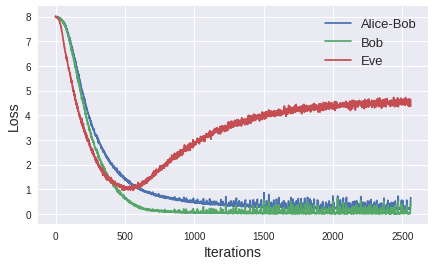

In [ ]:

plt.figure(figsize=(7, 4))
plt.plot(ab_losses, label='Alice-Bob')
plt.plot(bob_losses, label='Bob')
plt.plot(eve_losses, label='Eve')

plt.xlabel("Iterations", fontsize=14)
plt.ylabel("Loss", fontsize=14)
plt.legend(fontsize=13)
plt.show()

In [ ]:
samples = 20000

m_batch = np.random.randint(0, 2, msg * samples).reshape(samples, msg)
k_batch = np.random.randint(0, 2, msg * samples).reshape(samples, msg)
print(m_batch[68,])
print(k_batch[68,])
alice_encipher = alice.predict([m_batch, k_batch])
print(alice_encipher[68,])
bob_plaintxt = (bob.predict([alice_encipher, k_batch]) > 0.5).astype(int)
print(bob_plaintxt[68,])
eve_plaintxt = (eve.predict(alice_encipher) > 0.5).astype(int)
print(eve_plaintxt[68,])
bob_diff = np.abs(m_batch - bob_plaintxt)
bob_total = np.sum(bob_diff, axis=-1)
eve_diff = np.abs(m_batch - eve_plaintxt)
eve_total = np.sum(eve_diff, axis=-1)

print("Bob is ",100.0*np.sum(bob_total == 0) / samples,'% correct')
print("Eve is ",100.0*np.sum(eve_total == 0) / samples,'% correct')

[0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 0]
[0 1 1 0 0 1 0 1 0 0 1 1 1 1 0 0]
[0.24208611 0.4327162  0.52912605 0.21150425 0.38251728 0.5678212
 0.6677761  0.3689691  0.37090844 0.43058178 0.58825314 0.5506817
 0.43998745 0.46891993 0.46717468 0.40968207]
[0 1 0 1 1 1 1 1 0 0 0 1 0 1 0 0]
[0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0]
Bob is  60.165 % correct
Eve is  0.29 % correct
